In [1]:
import sys
sys.path.append('../..')
from dataloader import *
from model import *
from train_eval_test import *
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
import pandas as pd

2024-01-25 15:59:35.955737: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-25 15:59:36.061932: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-25 15:59:37.254641: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/cuda-11.6/lib64:/usr/local/cuda-12.2/lib64
2024-01-25 15:59:37.254951: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror:

## Load data

In [2]:
torch.manual_seed(7)

In [3]:
solar_data = pd.read_csv('../../data/solar.csv', header=None).to_numpy()

In [4]:
batch_size = 32
n_train = 36601
n_eval = 5161
n_test = 10417
train_loader, eval_loader, test_loader = get_loaders(solar_data, batch_size, n_train, n_eval, n_test, T=96, S=96)

## Train 

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
#writer = SummaryWriter()

cuda


In [6]:
N = 137 
T = 96 
D = 512 
S = 96 
hidden_dim = 512 
num_blocks = 2 

itransformer = iTransformer(N, T, D, S, hidden_dim, num_blocks).to(device)
optimizer = torch.optim.Adam(itransformer.parameters(), lr=1e-4, weight_decay= 1e-5) 



In [7]:
loss_values, loss_eval = train(itransformer, optimizer, train_loader, eval_loader, 10, device)

---- epoch :  0
loss train : 0.34620019422613874
loss eval : 0.19541819773192676
---- epoch :  1
loss train : 0.312508924803015
loss eval : 0.1789351301092022
---- epoch :  2
loss train : 0.3009227276840929
loss eval : 0.17398138325544274
---- epoch :  3
loss train : 0.2943359006532549
loss eval : 0.17104666019385717
---- epoch :  4
loss train : 0.2898975127914514
loss eval : 0.16522990973115717
---- epoch :  5
loss train : 0.28607030074445955
loss eval : 0.17099535245003192
---- epoch :  6
loss train : 0.28245141912875316
loss eval : 0.16412324247495183
---- epoch :  7
loss train : 0.27935008255407334
loss eval : 0.16455745153457113
---- epoch :  8
loss train : 0.27649405846775466
loss eval : 0.1617018127310201
---- epoch :  9
loss train : 0.27303132540191294
loss eval : 0.16860009148810645


## Test

In [8]:
loss_test, loss_mae, target, yhat = test(itransformer, test_loader, device)
print("MSE : ", loss_test)
print("MAE : ", loss_mae)

MSE :  0.22269941591614448
MAE :  0.2628413113093598


In [9]:
target.shape

torch.Size([17, 96, 137])

Affichage pour une modalité sur toute la durée de la prédiction

Affichage de toutes les modalités à un instant t

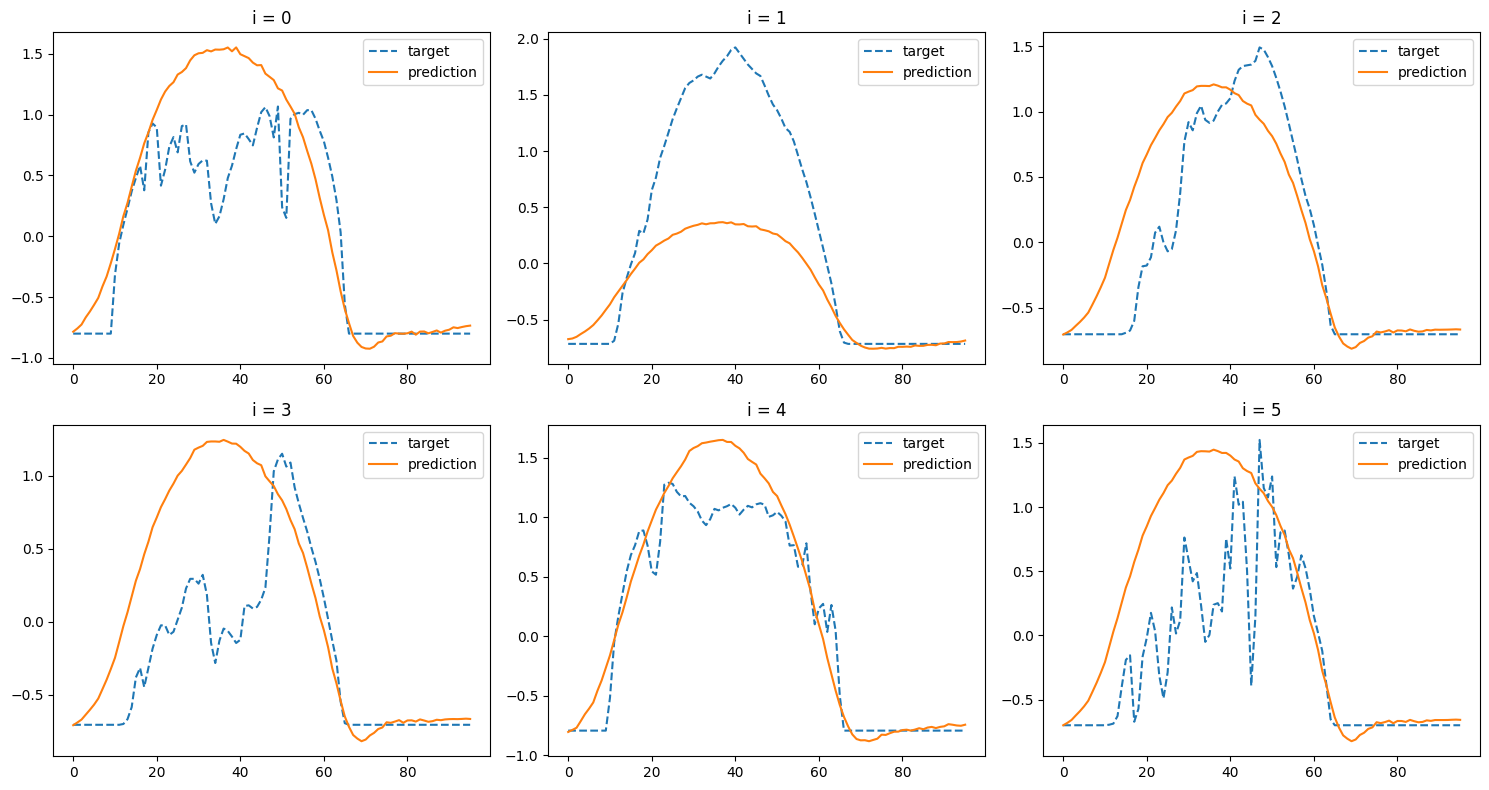

In [10]:
plt.figure(figsize=(15, 8))

for i in range(1, 7):
    plt.subplot(2, 3, i)
    current_i = i - 1
    
    plt.plot(target[0, :, current_i].to("cpu"), "--", label="target")
    plt.plot(yhat[0, :, current_i].to("cpu"), label="prediction")
    
    plt.title(f"i = {current_i}")
    plt.legend()

plt.tight_layout()
plt.show()

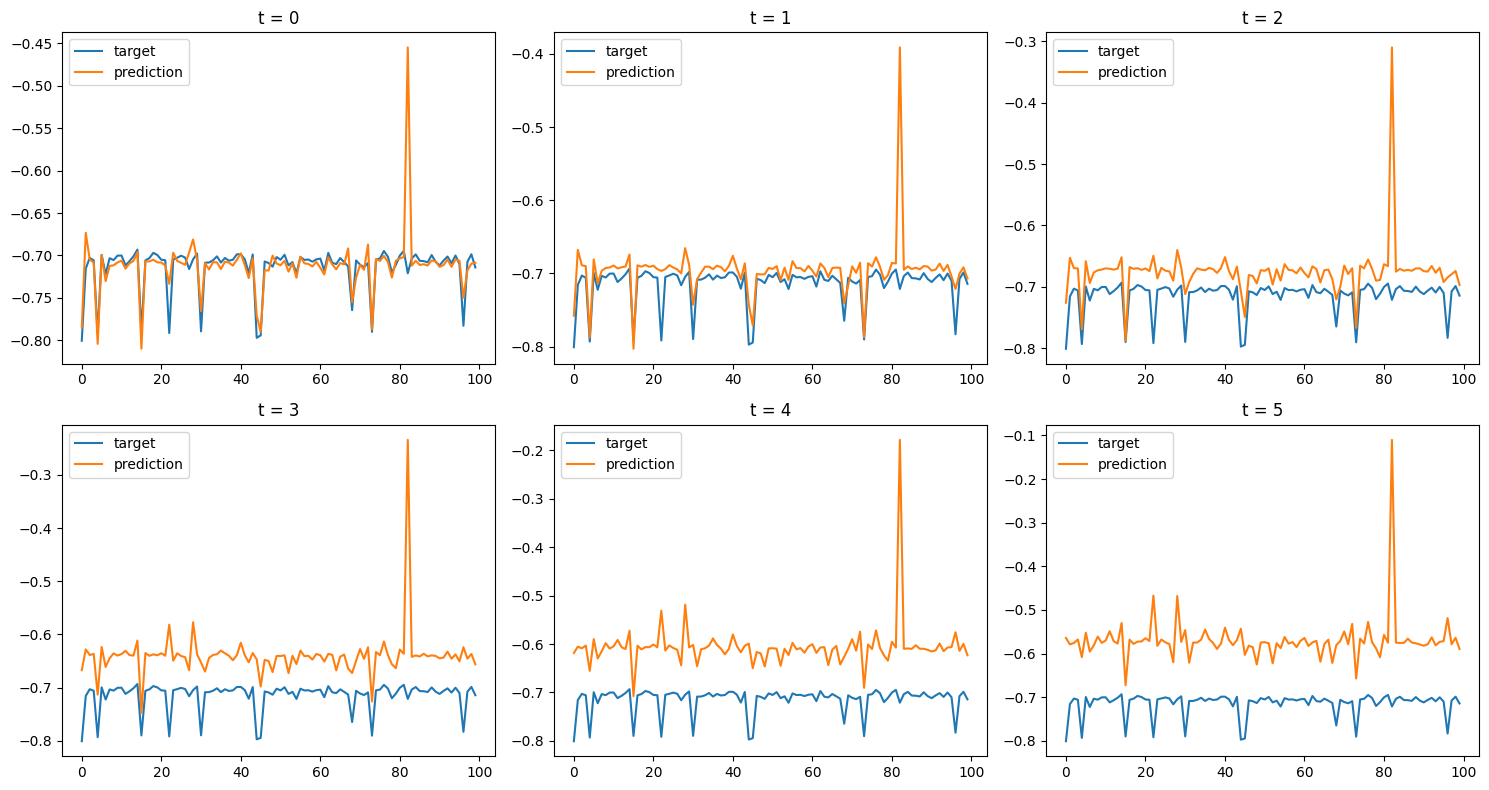

In [11]:
plt.figure(figsize=(15, 8))

for i in range(1, 7):
    plt.subplot(2, 3, i)
    
    current_i = i-1
    
    plt.plot(np.arange(len(target[1, current_i, :100])), target[0, current_i, :100].cpu(),  label="target")
    plt.plot(np.arange(len(target[1, current_i, :100])), yhat[0, current_i, :100].cpu(),  label="prediction")


    plt.title(f"t = {current_i}")
    plt.legend()

plt.tight_layout()
plt.show()

### Save correlation pdf

In [12]:
PATH = "resultats/correlations"
BATCH_SIZE = 32
NB_BATCH_SAVE = 30
NB_TEST_PER_BATCH = 3


def save(dataset, Att_first, Att_last, corr_lookback, corr_lookforward, nb_test, i):
    fig = plt.figure(figsize=(5, 5))

    ax1 = plt.subplot2grid((2, 2), (0, 0))
    im1 = ax1.imshow(corr_lookback, cmap='viridis', interpolation='nearest')
    ax1.set_title('Lookback correlations')

    ax2 = plt.subplot2grid((2, 2), (0, 1))
    im2 = ax2.imshow(corr_lookforward, cmap='viridis', interpolation='nearest')
    ax2.set_title('Future correlations')
    ax3 = plt.subplot2grid((2, 2), (1, 0))
    
    im3 = ax3.imshow(Att_first, cmap='viridis', interpolation='nearest')
    ax3.set_title('Score map of layer 1')

    ax4 = plt.subplot2grid((2, 2), (1, 1))
    im4 = ax4.imshow(Att_last, cmap='viridis', interpolation='nearest')
    ax4.set_title('Score map of layer L')
    
    cbar_ax = fig.add_axes([1, 0.1, 0.02, 0.8])
    fig.colorbar(im1, cax=cbar_ax)

    plt.tight_layout()
    plt.savefig(f"{PATH}/{dataset}/coor_att_{nb_test}_{i}.png")

    print(f"save {PATH}/{dataset}/coor_att_{nb_test}_{i}.png")


def calcule_att_corr(dataset, itransformer, x, y, nb_test, i): 
    A_first = itransformer.liste_attention[0] #attention maps first layer
    A_last = itransformer.liste_attention[-1] #attention maps last layer

    liste_idx_examples = torch.randint(32, (5,))

    #calcule des matrices de correlation
    c_lookback = x[i,:,:].T.cpu()
    corr_lookback = np.corrcoef(c_lookback)
    c_lookforward = y[i,:,:].T.cpu()
    corr_lookforward = np.corrcoef(c_lookforward)

    Att_first = A_first[i, 0, :, :].detach().to('cpu')
    Att_last = A_last[i, 0, :, :].detach().to('cpu')

    return Att_first, Att_last, corr_lookback, corr_lookforward


In [13]:
num_test = 0
for x,y in test_loader : 
    if num_test == 12: 
        itransformer.liste_attention = []
        x = x.float().to(device)
        itransformer(x, True)

        Att_first1, Att_last1, corr_lookback1, corr_lookforward1 = calcule_att_corr("traffic", itransformer, x, y, num_test, 25)

    if num_test == 13: 
        itransformer.liste_attention = []
        x = x.float().to(device)
        itransformer(x, True)

        Att_first2, Att_last2, corr_lookback2, corr_lookforward2 = calcule_att_corr("traffic", itransformer, x, y, num_test, 0)
    
    num_test+=1
    


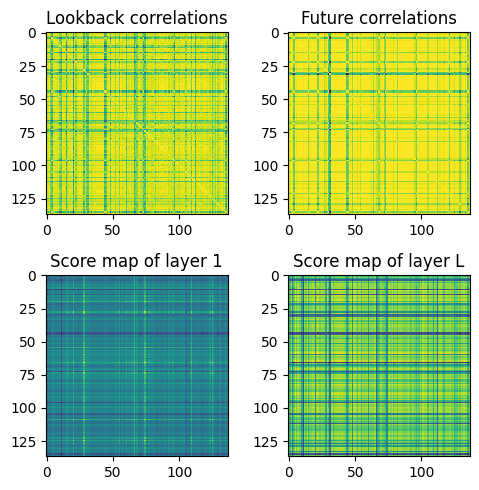

In [46]:
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch

fig, axs = plt.subplots(2, 2, figsize=(5, 5))

# Première figure
axs[0,0].imshow(corr_lookback1, cmap='viridis', interpolation='nearest')
axs[0,0].set_title('Lookback correlations')

axs[0,1].imshow(corr_lookforward1, cmap='viridis', interpolation='nearest')
axs[0,1].set_title('Future correlations')

axs[1,0].imshow(Att_first1, cmap='viridis', interpolation='nearest')
axs[1,0].set_title('Score map of layer 1')

axs[1,1].imshow(Att_last1, cmap='viridis', interpolation='nearest')
axs[1,1].set_title('Score map of layer L')

plt.tight_layout()
plt.savefig(f"{PATH}/{dataset}/coor_att_1.png")
plt.show()






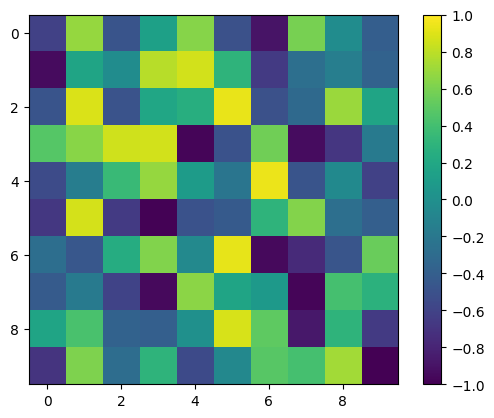

In [69]:
data = np.random.uniform(-1, 1, size=(10, 10))

# Afficher l'image avec une barre de couleur
fig, axs = plt.subplots()
im = axs.imshow(data, vmin=-1, vmax=1)

# Ajouter la barre de couleur avec les valeurs de -1 à 1
cbar = plt.colorbar(im, ax=axs, ticks=np.linspace(-1, 1, 11))

plt.show()

/tmp/ipykernel_99301/3049602806.py:21: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


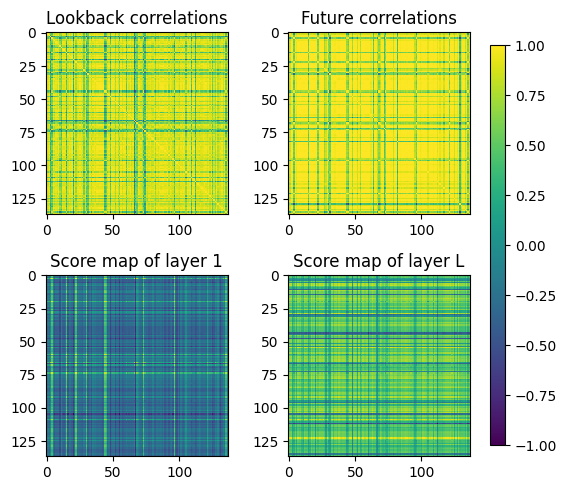

In [70]:
from matplotlib.colors import Normalize

fig, axs = plt.subplots(2, 2, figsize=(5, 5))

# Deuxième figure
axs[0,0].imshow(corr_lookback2, cmap='viridis', interpolation='nearest')
axs[0,0].set_title('Lookback correlations')

axs[0,1].imshow(corr_lookforward2, cmap='viridis', interpolation='nearest')
axs[0,1].set_title('Future correlations')

axs[1,0].imshow(Att_first2, cmap='viridis', interpolation='nearest')
axs[1,0].set_title('Score map of layer 1')

axs[1,1].imshow(Att_last2, cmap='viridis', interpolation='nearest')
axs[1,1].set_title('Score map of layer L')

plt.colorbar(im, ax=axs.ravel().tolist(), cax=fig.add_axes([1,0.1,0.03,0.8])  )

plt.tight_layout()
plt.savefig(f"{PATH}/{dataset}/coor_att_2.png")

plt.show()